# Unit 6. Essential Deep Learning Tips & Tricks

# 6.2 Learning Rates and Learning Rate Schedulers

## Part 3. Using an Automatic Learning Rate Finder

In [13]:
import lightning as L
import torch
from lightning.pytorch.loggers import CSVLogger

from shared_utilities import CustomDataModule, LightningModel, PyTorchMLP
import os

In [3]:
torch.manual_seed(123)
dm = CustomDataModule()

pytorch_model = PyTorchMLP(num_features=100, num_classes=2)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

## Lightning < 2.0

```python

trainer = L.Trainer(
    max_epochs=100,
    auto_lr_find=True,  # New!!!
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),    
    deterministic=True,
)

results = trainer.tune(model=lightning_model, datamodule=dm)
```

## Lightning >= 2.0

In [4]:
from lightning.pytorch.tuner import Tuner

trainer = L.Trainer(
    max_epochs=100,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),    
    deterministic=True,
)


# Create a Tuner
tuner = Tuner(trainer)

# finds learning rate automatically
# sets hparams.lr or hparams.learning_rate to that learning rate
lr_finder = tuner.lr_find(lightning_model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/my-model
/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


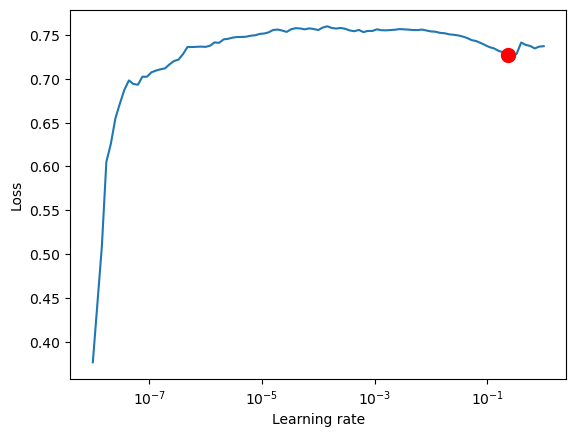

In [5]:
fig = lr_finder.plot(suggest=True)
#fig.savefig("lr_suggest.pdf")

In [6]:
# get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)

0.2290867652767775


In [7]:
# update hparams of the model
lightning_model.learning_rate = new_lr

In [8]:
trainer.fit(model=lightning_model, datamodule=dm)


  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 15.3 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)


/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 99: 100%|██████████| 450/450 [00:01<00:00, 235.38it/s, v_num=0, val_loss=0.637, val_acc=0.679, train_acc=0.729]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 450/450 [00:01<00:00, 234.02it/s, v_num=0, val_loss=0.637, val_acc=0.679, train_acc=0.729]


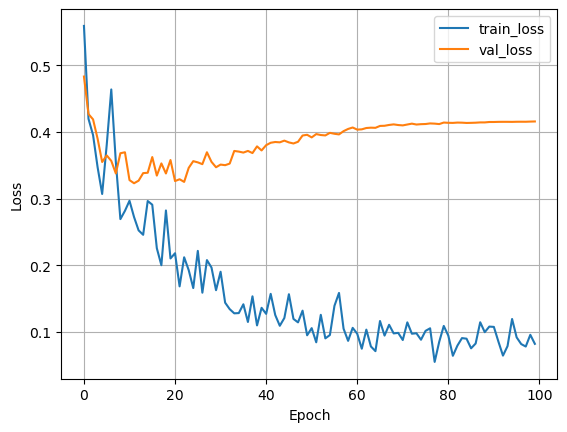

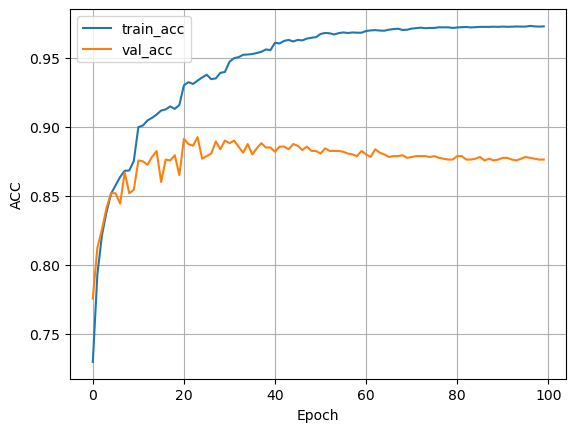

In [15]:
### Plot
import matplotlib.pyplot as plt
import pandas as pd

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

dir_name = 'suggested_lr'

if not os.path.exists(dir_name):
    os.mkdir(dir_name)

plt.savefig(f"{dir_name}/suggest_loss.png")

df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.savefig(f"{dir_name}/suggest_acc.png")

plt.show()

In [10]:
trainer.test(model=lightning_model, dataloaders=dm)

/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 125/125 [00:00<00:00, 488.05it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6882500052452087     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.6882500052452087}]